In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow.keras.backend as K
from tqdm import tqdm
import seaborn as sns
%matplotlib inline
import os
import sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

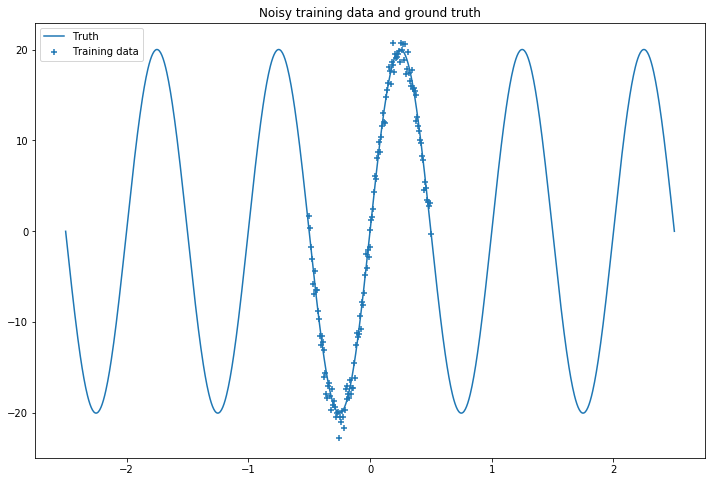

In [2]:
figsize=(12,8)
def f_sin(x, sigma):
    epsilon = np.random.randn(*x.shape) * sigma
    return 20 * np.sin(2 * np.pi * (x)) + epsilon

def f_lin(x, sigma):
    y = []
    for el in x:
        y.append(0.25*el)
        if sigma != 0:
            y[-1] += np.random.randn() * sigma*el*0.05

    return np.asarray(y)


f = f_sin
train_size = 128
noise = 1.0

fig = plt.figure(figsize=figsize)
X_train_1 = np.linspace(-.5, .5, train_size).tolist()
#X_train_2 = np.linspace(1.0, 1.25, train_size/2).tolist()
X_train = np.asarray(X_train_1).reshape(-1, 1)
X_test = np.linspace(-2.5, 2.5, 1000).reshape(-1, 1)
y_train = f(X_train, sigma=noise)
y_test = f(X_test, sigma=0.0)

plt.scatter(X_train, y_train, marker='+', label='Training data')
plt.plot(X_test, y_test, label='Truth')
plt.title('Noisy training data and ground truth')
plt.legend();

In [3]:
# constants
epochs = 1000
units = 20

## Simple neural network

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


training: 100%|██████████| 1000/1000 [00:00<00:00, 1437.77it/s]


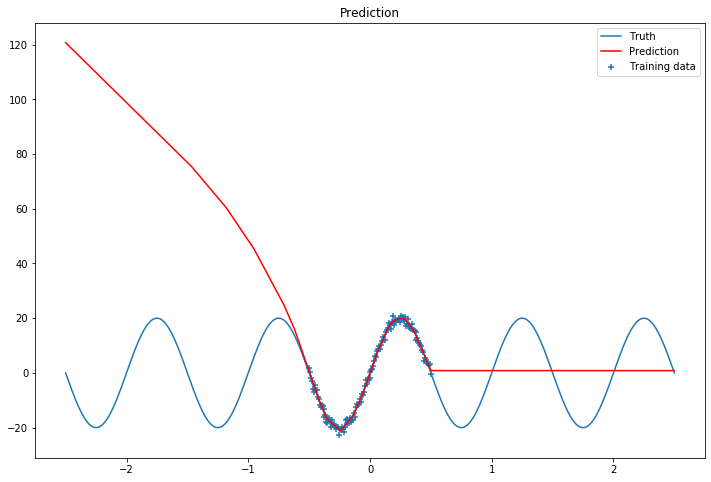

In [4]:
tf.reset_default_graph()
in_placeholder = tf.compat.v1.placeholder(tf.float32, shape=(None, 1))
out_placeholder = tf.compat.v1.placeholder(tf.float32, shape=(None, 1))


input = tf.keras.layers.Input(shape=(1,))
x = tf.keras.layers.Dense(units, activation="relu")(input)
x = tf.keras.layers.Dense(units, activation="relu")(x)
x = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(input, x)

y_pred_op = model(in_placeholder)
loss_op = tf.reduce_mean(tf.pow(y_pred_op - out_placeholder, 2))

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=0.03)
train_op = optimizer.minimize(loss_op)
init_op = tf.group(tf.compat.v1.global_variables_initializer(),
                     tf.compat.v1.local_variables_initializer())

sess = tf.compat.v1.Session()

sess.run(init_op)
for step in tqdm(range(epochs), desc="training"):
  _, loss = sess.run([train_op, loss_op], feed_dict={
    in_placeholder: X_train,
    out_placeholder: y_train,
    K.learning_phase(): 1
  })

y_pred = sess.run(y_pred_op, feed_dict={
        in_placeholder: X_test
    })

fig = plt.figure(figsize=figsize)
plt.plot(X_test, y_test, label='Truth')
plt.plot(X_test, y_pred, 'r-', label='Prediction')
plt.scatter(X_train, y_train, marker='+', label='Training data')
plt.title('Prediction')
plt.legend();

## Dropout network

In [7]:
inference_samples = 100

In [8]:
def mc_drop_experiment(drop_rate, first_drop=True, second_drop=True):
    tf.reset_default_graph()
    in_placeholder = tf.compat.v1.placeholder(tf.float32, shape=(None, 1))
    out_placeholder = tf.compat.v1.placeholder(tf.float32, shape=(None, 1))


    dropout_switch = tf.compat.v1.placeholder(dtype="bool")
    input = tf.keras.layers.Input(shape=(1,))
    x = tf.keras.layers.Dense(units, activation="relu")(input)
    if first_drop:
        x = tf.keras.layers.Dropout(drop_rate)(x, training=dropout_switch)
    x = tf.keras.layers.Dense(units, activation="relu")(x)
    if second_drop:
        x = tf.keras.layers.Dropout(drop_rate)(x, training=dropout_switch)
    x = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(input, x)

    y_pred_op = model(in_placeholder)
    loss_op = tf.reduce_mean(tf.pow(y_pred_op - out_placeholder, 2))

    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=0.03)
    train_op = optimizer.minimize(loss_op)
    init_op = tf.group(tf.compat.v1.global_variables_initializer(),
                         tf.compat.v1.local_variables_initializer())

    sess = tf.compat.v1.Session()

    sess.run(init_op)
    for step in tqdm(range(epochs), desc="training"):
      _, loss = sess.run([train_op, loss_op], feed_dict={
        in_placeholder: X_train,
        out_placeholder: y_train,
        dropout_switch: True,
        K.learning_phase(): 0
      })

    y_pred_list = []
    for i in tqdm(range(inference_samples), desc="inference"):
        y_pred = sess.run(y_pred_op, feed_dict={
            in_placeholder: X_test,
            dropout_switch: True,
            K.learning_phase(): 1
        })
        y_pred_list.append(y_pred)

    y_preds = np.concatenate(y_pred_list, axis=1)
    y_mean = np.mean(y_preds, axis=1)
    y_sigma = np.std(y_preds, axis=1)

    fig = plt.figure(figsize=figsize)
    plt.plot(X_test, y_test, label='Truth')
    plt.plot(X_test, y_mean, 'r-', label='Predictive mean')
    plt.scatter(X_train, y_train, marker='+', label='Training data')
    plt.fill_between(X_test.ravel(),
                     y_mean + 3 * y_sigma,
                     y_mean - 3 * y_sigma,
                     alpha=0.5, label='Epistemic uncertainty')
    plt.title('Prediction')
    plt.legend();

inference: 100%|██████████| 100/100 [00:00<00:00, 1119.17it/s]


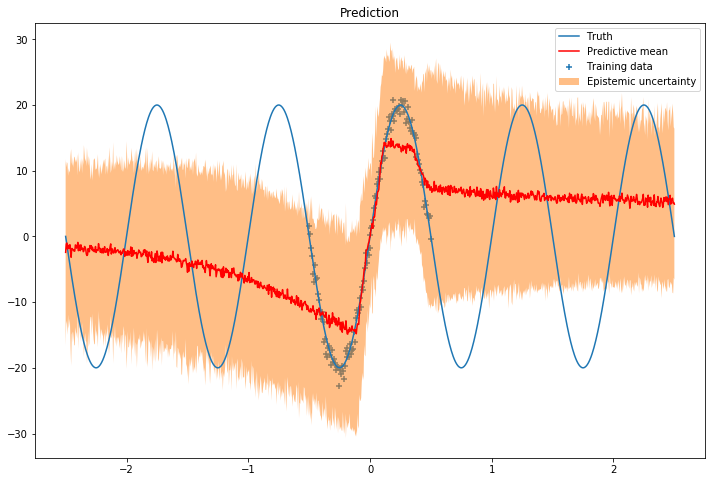

In [9]:
mc_drop_experiment(drop_rate=0.5, first_drop=True, second_drop=True)

inference: 100%|██████████| 100/100 [00:00<00:00, 1391.62it/s]


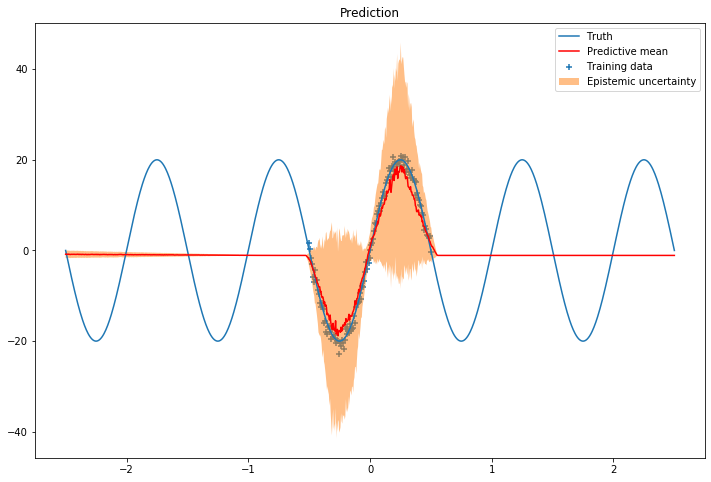

In [10]:
mc_drop_experiment(drop_rate=0.5, first_drop=False, second_drop=True)

inference: 100%|██████████| 100/100 [00:00<00:00, 1294.38it/s]


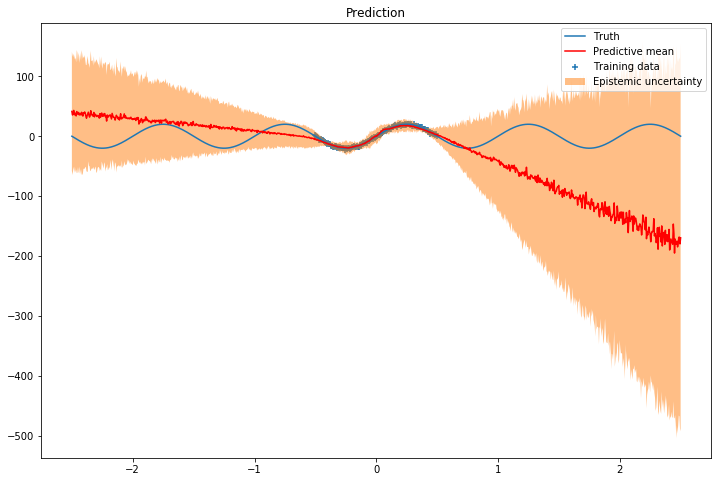

In [11]:
mc_drop_experiment(drop_rate=0.5, first_drop=True, second_drop=False)

## Bayesian Net

In [68]:
def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t, scale=1),
            reinterpreted_batch_ndims=1)),
    ])

conv_variational_det_sample = tf.compat.v1.placeholder(dtype="bool", name="conv_variational_det_sample")

def bnn_experiment(kl_annealing=1, noise=1):
    tf.reset_default_graph()
    in_placeholder = tf.compat.v1.placeholder(tf.float32, shape=(None, 1))
    out_placeholder = tf.compat.v1.placeholder(tf.float32, shape=(None, 1))
    
    input = tf.keras.layers.Input(shape=(1,))
    x = tfp.layers.DenseFlipout(units, activation="relu", kernel_posterior_tensor_fn=lambda d: tf.cond(conv_variational_det_sample, 
                                                d.mean, d.sample))(input)
    x = tfp.layers.DenseFlipout(units, activation="relu",
                               kernel_posterior_tensor_fn=lambda d: tf.cond(conv_variational_det_sample, 
                                                d.mean, d.sample))(x)
    x = tfp.layers.DenseFlipout(1)(x)
    model = tf.keras.Model(input, x)
    y_pred_op = model(in_placeholder)
    
    y_dist = tfp.distributions.Normal(loc=y_pred_op,scale=noise)
    
    
    loss_op = tf.reduce_mean(tf.pow(y_pred_op - out_placeholder, 2))
    t = tf.compat.v2.Variable(0.0)
    if kl_annealing == -1:
        kl_regularizer = 0
    else:
        kl_regularizer = t / kl_annealing
    log_likelihood = y_dist.log_prob(out_placeholder)
    neg_log_likelihood = -tf.reduce_mean(log_likelihood)
    kl_weight = 1. / train_size
    kl = sum(model.losses) * kl_weight * tf.minimum(1.0, kl_regularizer)
    #elbo_loss = neg_log_likelihood + kl
    elbo_loss = loss_op + kl
    update_step_op = tf.compat.v1.assign(t, t + 1)

    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=0.03)
    train_op = optimizer.minimize(elbo_loss)
    init_op = tf.group(tf.compat.v1.global_variables_initializer(),
                         tf.compat.v1.local_variables_initializer())

    sess = tf.compat.v1.Session()

    sess.run(init_op)
    for step in tqdm(range(epochs), desc="training"):
        _, loss, _ = sess.run([train_op, elbo_loss, update_step_op], feed_dict={
            in_placeholder: X_train,
            out_placeholder: y_train,
            conv_variational_det_sample: True
          })
        #if step % 50 == 0:
            #print("[%d/%d] loss: %.2f" % (step, epochs, loss))
        #    print("loss:", loss)

    y_pred_list = []
    for i in tqdm(range(inference_samples), desc="inference"):
        y_pred = sess.run(y_pred_op, feed_dict={
            in_placeholder: X_test,
            conv_variational_det_sample: True
        })

        y_pred_list.append(y_pred)

    y_preds = np.concatenate(y_pred_list, axis=1)
    y_mean = np.mean(y_preds, axis=1)
    y_sigma = np.std(y_preds, axis=1)

    fig = plt.figure(figsize=figsize)
    plt.plot(X_test, y_test, label='Truth')
    plt.plot(X_test, y_mean, 'r-', label='Predictive mean')
    plt.scatter(X_train, y_train, marker='+', label='Training data')
    plt.fill_between(X_test.ravel(), y_mean + 3 * y_sigma, y_mean - 3 * y_sigma, alpha=0.5, label='Epistemic uncertainty')
    plt.title('Prediction')
    #plt.ylim((-5,5))
    plt.legend();


In [69]:
bnn_experiment(kl_annealing=100, noise=1)

ValueError: in converted code:

    /Users/gchlebus/anaconda2/envs/bayesian_nn/lib/python3.6/site-packages/tensorflow_probability/python/layers/dense_variational.py:172 call
        outputs = self._apply_variational_kernel(inputs)
    /Users/gchlebus/anaconda2/envs/bayesian_nn/lib/python3.6/site-packages/tensorflow_probability/python/layers/dense_variational.py:686 _apply_variational_kernel
        self.kernel_posterior_tensor_fn(self.kernel_posterior_affine))
    <ipython-input-68-1ad3d06a601a>:19 <lambda>
        d.mean, d.sample))(input)
    /Users/gchlebus/anaconda2/envs/bayesian_nn/lib/python3.6/site-packages/tensorflow_core/python/util/deprecation.py:507 new_func
        return func(*args, **kwargs)
    /Users/gchlebus/anaconda2/envs/bayesian_nn/lib/python3.6/site-packages/tensorflow_core/python/ops/control_flow_ops.py:1224 cond
        orig_res_t, res_t = context_t.BuildCondBranch(true_fn)
    /Users/gchlebus/anaconda2/envs/bayesian_nn/lib/python3.6/site-packages/tensorflow_core/python/ops/control_flow_ops.py:1077 BuildCondBranch
        self._BuildCondTensor, original_result, expand_composites=True)
    /Users/gchlebus/anaconda2/envs/bayesian_nn/lib/python3.6/site-packages/tensorflow_core/python/util/nest.py:536 map_structure
        structure[0], [func(*x) for x in entries],
    /Users/gchlebus/anaconda2/envs/bayesian_nn/lib/python3.6/site-packages/tensorflow_core/python/util/nest.py:536 <listcomp>
        structure[0], [func(*x) for x in entries],
    /Users/gchlebus/anaconda2/envs/bayesian_nn/lib/python3.6/site-packages/tensorflow_core/python/ops/control_flow_ops.py:1056 _BuildCondTensor
        return self._ProcessOutputTensor(ops.convert_to_tensor(v))
    /Users/gchlebus/anaconda2/envs/bayesian_nn/lib/python3.6/site-packages/tensorflow_core/python/ops/control_flow_ops.py:1041 _ProcessOutputTensor
        real_val = _SwitchRefOrTensor(real_val, self._pred)[self._branch]
    /Users/gchlebus/anaconda2/envs/bayesian_nn/lib/python3.6/site-packages/tensorflow_core/python/ops/control_flow_ops.py:362 _SwitchRefOrTensor
        return switch(data, pred, name=name)
    /Users/gchlebus/anaconda2/envs/bayesian_nn/lib/python3.6/site-packages/tensorflow_core/python/ops/control_flow_ops.py:305 switch
        with ops.name_scope(name, "Switch", [data, pred]) as name:
    /Users/gchlebus/anaconda2/envs/bayesian_nn/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py:6334 __enter__
        g_from_inputs = _get_graph_from_inputs(self._values)
    /Users/gchlebus/anaconda2/envs/bayesian_nn/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py:5979 _get_graph_from_inputs
        _assert_same_graph(original_graph_element, graph_element)
    /Users/gchlebus/anaconda2/envs/bayesian_nn/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py:5914 _assert_same_graph
        (item, original_item))

    ValueError: Tensor("cond/pred_id:0", dtype=bool) must be from the same graph as Tensor("dense_flipout/mul:0", shape=(1, 20), dtype=float32).


In [53]:
def bnn_experiment(kl_weight, learn_noise=False, mode=0):
    tf.reset_default_graph()
    in_placeholder = tf.compat.v1.placeholder(tf.float32, shape=(None, 1))
    out_placeholder = tf.compat.v1.placeholder(tf.float32, shape=(None, 1))

    if mode == 0:
        input = tf.keras.layers.Input(shape=(1,))
        x = tfp.layers.DenseFlipout(units, activation="relu")(input)
        x = tfp.layers.DenseFlipout(units, activation="relu")(x)
        x = tfp.layers.DenseFlipout(1)(x)
        model = tf.keras.Model(input, x)
        y_pred_op = model(in_placeholder)
        y_dist = tfp.distributions.Normal(loc=y_pred_op,scale=noise)
    else:       
        input = tf.keras.layers.Input(shape=(1,))
        x = tfp.layers.DenseFlipout(units, activation="relu")(input)
        x = tfp.layers.DenseFlipout(units, activation="relu")(x)
        if learn_noise:
            x = tfp.layers.DenseFlipout(1+1)(x)
            x = tfp.layers.DistributionLambda(lambda t:
                tfp.distributions.Normal(loc=t[...,0:1],
                                    scale=tf.exp(t[...,1:2])))(x)
        else:
            x = tfp.layers.DenseFlipout(1)(x)
            x = tfp.layers.DistributionLambda(lambda t:
                tfp.distributions.Normal(loc=t[...,0:1],
                                        scale=noise))(x)

        model = tf.keras.Model(input, x)
        y_dist = model(in_placeholder)

    
    t = tf.compat.v2.Variable(0.0)
    kl_annealing = 1
    kl_regularizer = t / kl_annealing
    log_likelihood = y_dist.log_prob(out_placeholder)
    neg_log_likelihood = -tf.reduce_mean(log_likelihood)
    kl = sum(model.losses) * kl_weight * tf.minimum(1.0, kl_regularizer)
    elbo_loss = neg_log_likelihood + kl
    update_step_op = tf.compat.v1.assign(t, t + 1)

    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=0.01)
    train_op = optimizer.minimize(elbo_loss)
    init_op = tf.group(tf.compat.v1.global_variables_initializer(),
                         tf.compat.v1.local_variables_initializer())

    sess = tf.compat.v1.Session()

    sess.run(init_op)
    for step in tqdm(range(epochs), desc="training"):
        _, loss, _ = sess.run([train_op, elbo_loss, update_step_op], feed_dict={
            in_placeholder: X_train,
            out_placeholder: y_train
          })
        #if step % 100 == 0:
        #    print("loss:", loss)

    y_pred_list = []
    for i in tqdm(range(inference_samples), desc="inference"):
        if mode == 0:
            y_pred = sess.run(y_pred_op, feed_dict={
                in_placeholder: X_test
            })
        else:
            y_pred = sess.run(y_dist.mean(), feed_dict={
                in_placeholder: X_test
            })
        #if i == 0:
        #    print("y_pred.shape", y_pred.shape)
        y_pred_list.append(y_pred)

    y_preds = np.concatenate(y_pred_list, axis=1)
    y_mean = np.mean(y_preds, axis=1)
    y_sigma = np.std(y_preds, axis=1)

    fig = plt.figure(figsize=figsize)
    plt.plot(X_test, y_test, label='Truth')
    plt.plot(X_test, y_mean, 'r-', label='Predictive mean')
    plt.scatter(X_train, y_train, marker='+', label='Training data')
    plt.fill_between(X_test.ravel(), y_mean + 3 * y_sigma, y_mean - 3 * y_sigma, alpha=0.5, label='Epistemic uncertainty')
    plt.title('Prediction')
    plt.ylim((-20,20))
    plt.legend();

In [49]:
tf.reset_default_graph()
sess = tf.compat.v1.Session()

logits = [1, 50]
dist = tfp.distributions.OneHotCategorical(logits=logits)
sample = tf.constant([0, 1])
log_prob = dist.log_prob(sample)
sess.run(dist.probs)

array([5.2428857e-22, 1.0000000e+00], dtype=float32)